In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/COVID-19_Radiography_Dataset"

Mounted at /content/gdrive
 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia'
 Normal			     'Viral Pneumonia.metadata.xlsx'


In [28]:
#@markdown #**Anti-Disconnect for Google Colab**
#@markdown ## Run this to stop it from disconnecting automatically 
#@markdown  **(It will anyhow disconnect after 6 - 12 hrs for using the free version of Colab.)**
#@markdown  *(Colab Pro users will get about 24 hrs usage time)*
#@markdown ---
# taken from https://colab.research.google.com/github/justinjohn0306/VQGAN-CLIP/blob/main/VQGAN%2BCLIP_%28z%2Bquantize_method_with_augmentations%2C_user_friendly_interface%29.ipynb#scrollTo=XHyPd4oxVp_l stops colab disconnecting
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
IPython.display.Javascript(js_code)     

<IPython.core.display.Javascript object>

In [21]:
# import packages

import tensorflow as tf
from keras import datasets, layers, models
import keras as keras
import numpy as np
import pandas as pd
import matplotlib as plt
import os
import graphviz
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


# for reproducibility - ref https://machinelearningmastery.com/reproducible-results-neural-networks-keras/ and https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
np.random.seed(9)
tf.keras.utils.set_random_seed(10)

chest_xray_dataset = os.path.abspath("/content/gdrive/My Drive/COVID 19 CHEST XRAY/images")
chest_xray_dataset_annotations = os.path.abspath("/content/gdrive/My Drive/COVID 19 CHEST XRAY/metadata.csv")
radiography_dataset = os.path.abspath("/content/gdrive/My Drive/COVID-19_Radiography_Dataset/")
xray_covid19_dataset = os.path.abspath("/content/gdrive/My Drive/xray_dataset_covid19/")


Found 30306 files belonging to 3 classes.
Using 29700 files for training.
Found 30306 files belonging to 3 classes.
Using 606 files for validation.
class_names: ['COVID', 'Normal', 'Viral Pneumonia']


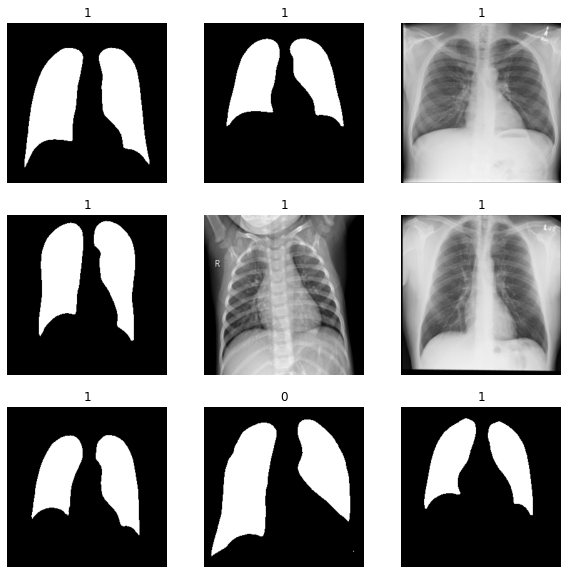

In [6]:
#Loading of images based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

image_size = (256, 256)
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(radiography_dataset, validation_split=0.02,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(radiography_dataset, validation_split=0.02,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
class_names = val_ds.class_names
print( "class_names: " + str( class_names ) )

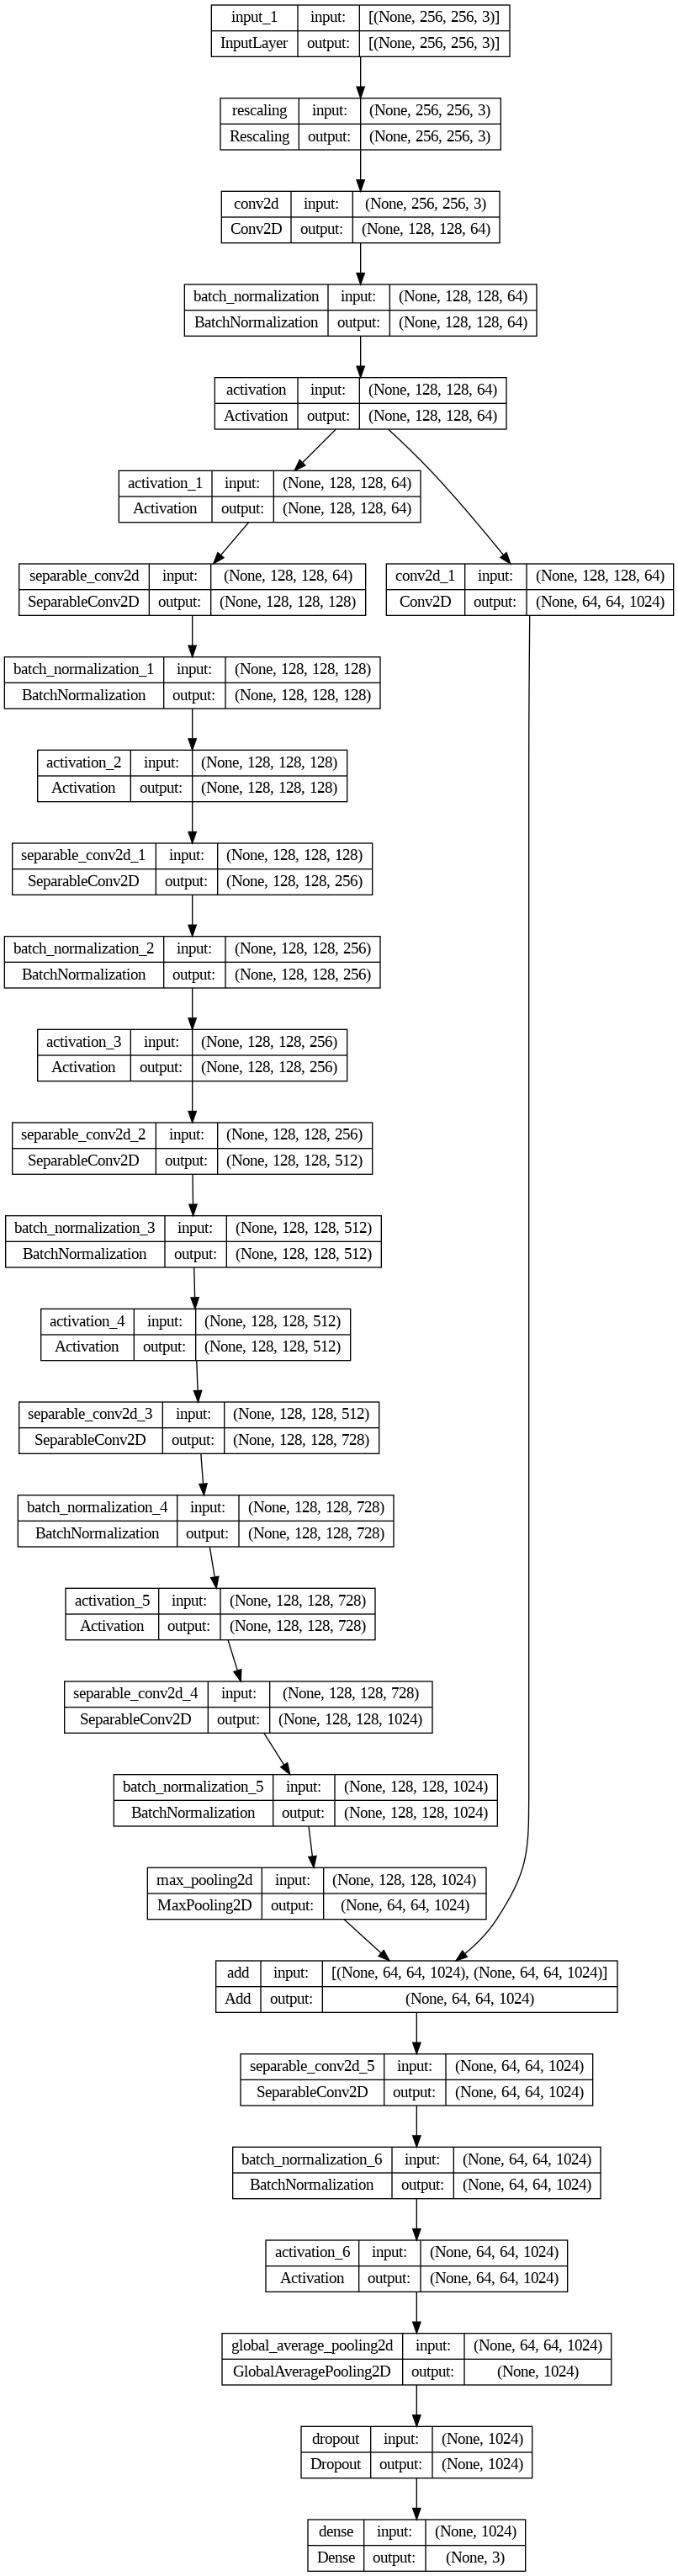

In [7]:
#CNN Model based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(64, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(256, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(512, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(728, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(1024, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(1024, (3,3), strides=2, padding="same")(
          previous_block_activation
      ) 
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = 3

    x = layers.Dropout(0)(x)
    outputs = layers.Dense(3, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=(image_size) + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

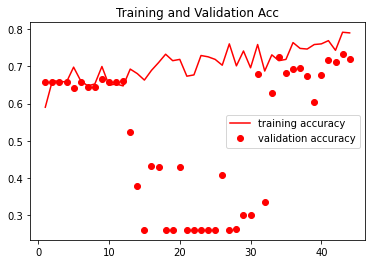

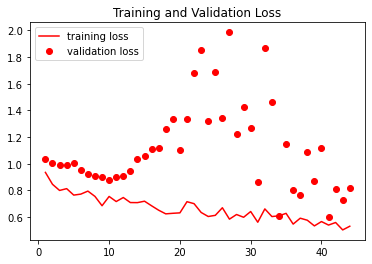

In [ ]:
epochs = 44

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"],
) 
model.summary()
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=18,
    callbacks=callbacks,
    validation_data=val_ds)
model.save('content/gdrive/My Drive/CNN_Models_Baseline/radiography_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Transfer Learning Model Baseline

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,386,795
Trainable params: 21,332,267
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/44
18/18 [==============================] - 55s 3s/step - loss: 0.8378 - acc: 0.6424 - val_loss: 3.6030 - val_acc: 0.6568
Epoch 2/44
18/18 [==============================] - 72s 4s/step - loss: 0.5484 - acc: 0.7378 - val_loss: 5.9941 - val_acc: 0.6568
Epoch 3/44
18/18 [=======================

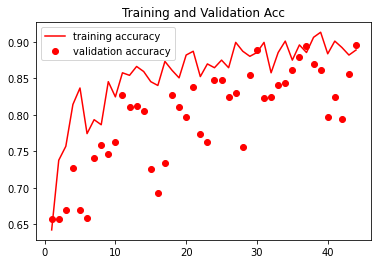

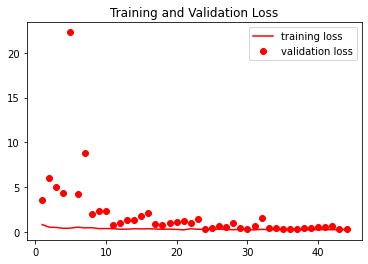

In [27]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
Xception_model = Sequential()
model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=3,
    classifier_activation="softmax",
)
Xception_model.add(model)
Xception_model.add(Dense(256,activation='relu'))
Xception_model.add(Dense(3,activation='softmax'))
epochs = 44

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
Xception_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"],
) 
Xception_model.summary()
history = Xception_model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=18,
    callbacks=callbacks,
    validation_data=val_ds)
Xception_model.save('content/gdrive/My Drive/CNN_Models_Baseline/xception_radiography_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_10 (Dense)            (None, 256)               524544    
                                                                 
 dense_11 (Dense)            (None, 3)                 771       
                                                                 
Total params: 24,090,115
Trainable params: 24,044,675
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/44
18/18 [==============================] - 16s 614ms/step - loss: 0.9053 - acc: 0.6493 - val_loss: 11657.0762 - val_acc: 0.6568
Epoch 2/44
18/18 [==============================] - 10s 567ms/step - loss: 0.6857 - acc: 0.7031 - val_loss: 4605.7144 - val_acc: 0.6568
Epoch 3/44
18/18 [==========

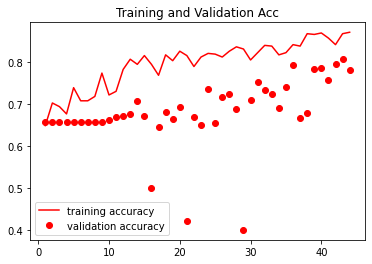

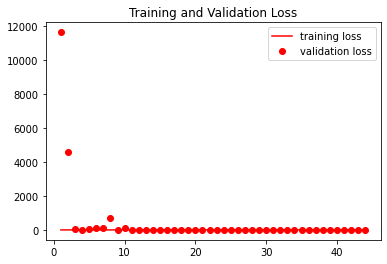

In [30]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
ResnetModel50V2_model = Sequential()
model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=3,
    classifier_activation="softmax",
)
ResnetModel50V2_model.add(model)
ResnetModel50V2_model.add(Dense(256,activation='relu'))
ResnetModel50V2_model.add(Dense(3,activation='softmax'))
epochs = 44

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
ResnetModel50V2_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"],
) 
ResnetModel50V2_model.summary()
history = ResnetModel50V2_model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=18,
    callbacks=callbacks,
    validation_data=val_ds)
ResnetModel50V2_model.save('content/gdrive/My Drive/CNN_Models_Baseline/resnetmodel50v2_radiography_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

82420632/82420632 [==============================] - 4s 0us/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense_12 (Dense)            (None, 256)               327936    
                                                                 
 dense_13 (Dense)            (None, 3)                 771       
                                                                 
Total params: 20,660,067
Trainable params: 20,506,195
Non-trainable params: 153,872
_________________________________________________________________
Epoch 1/44
18/18 [==============================] - 40s 1s/step - loss: 0.7125 - acc: 0.6875 - val_loss: 0.7760 - val_acc: 0.7591
Epoch 2/44
18/18 [=====================

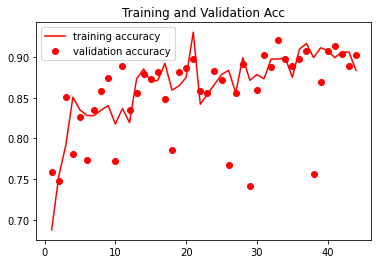

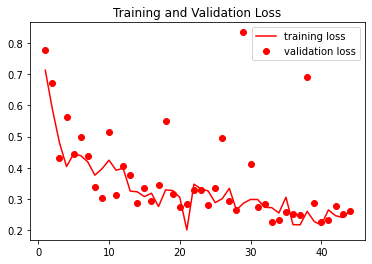

In [31]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
EfficientNetV2S_model	= Sequential()
model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=3,
    classifier_activation="softmax",
)
EfficientNetV2S_model.add(model)
EfficientNetV2S_model.add(Dense(256,activation='relu'))
EfficientNetV2S_model.add(Dense(3,activation='softmax'))
epochs = 44

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
EfficientNetV2S_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"],
) 
EfficientNetV2S_model.summary()
history = EfficientNetV2S_model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=18,
    callbacks=callbacks,
    validation_data=val_ds)
EfficientNetV2S_model.save('content/gdrive/My Drive/CNN_Models_Baseline/efficient_net_V2S_radiography_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()